# Numerical Experiments - Comparing Solution Spaces (partial random circulant matrices from Rademacher sequences)

In this notebook, we perform numerical experiments with random synthethically created data to compare the solution space of common sparse encoders to the multi-penalty framework and its solution space. By solution space comparison, we mean that we do not care about support selection or stopping criteria in this experiments. An algorithm is already considered as being successful if the correct support is anywhere among all supports that have been calculated while running the algorithm. 

The comparison will be between the multi-penalty framework and the following algorithms:
+ least absolute shrinkage and selection operator (LASSO) [1].
+ least-angle regression (LAR) [1].
+ iterative hard thresholding (IHT) [2].
+ preconditioned Lasso (pLASSO) [3].
+ orthogonal matching pursuit (OMP) [4].

Note that, of the tested algorithms, most do only have a single solution to a specific support size. For these, the experiments are equal to experiments where we simply give the support size as an oracle parameter/stopping criterion to the algorithm (OMP, LAR). For LASSO and pLASSO however, it can happen that multiple supports are found to a single support size. In this case, we look whether or not the generating support is among them, and if so, consider an experiment successfull.

In [1]:
methods = ['lasso', 'lar', 'iht', 'plasso', 'omp']

The code that is used to perform these experiments is contained in the repositories (https://github.com/soply/mpgraph, for the multi-penalty framework) and in https://github.com/soply/sparse_encoder_testsuite, where the other methods are implemented. The code is well-documented, therefore we refer for further information to these repositories. 

#### Creating the data for the experiments
The data is created by using the methods provided in the ```problem_factory``` subfolder of the ```mpgraph``` repository or the ```sparse_encoder_testsuite``` repository. Essentially, we use partial random circulant matrices (from a Rademacher sequence) $A \in \mathbb{R}^{m \times n}$, a random signal $u \in \mathbb{R}^n$ and random signal noise $v \in \mathbb{R}^n$. This yields $y = A(u+v)$. The characteristics of $u, v$ are specified in the problem dictionaries. Details on what the entries in this dictionaries mean can be found in the source code. Moreover, in some cases we add additional measurement noise on y.

## 0. Import the code to multi-penalty framework and sparse encoders

In [2]:
import sys
import numpy as np
relative_path_to_mp_source = '../tiling_graph/' # My relative path to the multi-penalty source code
relative_path_to_sparse_encoder_source = '../sparse_encoders_unmixing/' # My relative path to the sparse_encoders source code
sys.path.append(relative_path_to_mp_source)
sys.path.append(relative_path_to_sparse_encoder_source)
from mpgraph.run_multiple_batches import main as main_mp # Run method multi-penalty
from sparse_encoders.run_multiple_batches import main as main_se # Run method rest
from sparse_encoders.sparse_encoder_test_suite.plot_tools.multiple_methods_multiple_batches import success_vs_sparsity_level # Plotting results
from sparse_encoders.sparse_encoder_test_suite.plot_tools.multiple_methods_multiple_batches import success_vs_signal_noise
from sparse_encoders.sparse_encoder_test_suite.plot_tools.multiple_methods_multiple_batches import success_vs_signal_gap
# Defining the tiling creation options for multi-penalty LARS and multi-penalty LASSO methods
tiling_options_LARS = {
    'verbose': 0,
    'mode': 'LARS',
    'print_summary': False
}
tiling_options_LASSO = {
    'verbose': 0,
    'mode': 'LASSO',
    'print_summary': False
}

## 1.1 Case #measurements << #features
Here, we consider experiments where the number of measurements is much smaller than the number of features. The sparsity will be varied among the different cases.

In [87]:
# Specifying a problem
identifier_mms = 'prcm_rm_meas_much_smaller_feat_1' # For saving the files to some folder
random_seeds = [2074365993, 3608845689, 882858127, 4250122149, 2013921082, 2530214045, 2163201462, 3238461939, 1176474622, 
        1299165341, 318653059, 4109633665, 3784842373, 576600661, 2951085025, 747082525]
problem_mms = {
    'num_tests': 100, # Repititions per fixed experiment
    'n_measurements': 150, # = m 
    'n_features': 500, # = n
    'sparsity_level': [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 20, 25, 30, 35, 40], # Considered support sizes
    'smallest_signal': 1.5, # Lower bound for signal entries. One entry with smallest signal is ensured!
    'largest_signal': 5.0, # Upper bound for signal entries.
    'noise_type_signal': 'uniform_ensured_max', # Uniform sampling of entries of v + maximum will be taken.
    'noise_lev_signal': 0.2, # Bound for absolute of entires of v. 
    'noise_type_measurements': 'gaussian', # Does not matter since we have no measurement noise
    'noise_lev_measurements': 0.0, # No measurement noise
    'random_seed': list(random_seeds),
    'verbosity' : False,
    'sampling_matrix_type' : 'prcm_rademacher', # Partial random circulant for Rademacher sequences
    'problem_type' : 'unmixing',
}

#### Creating results for sparse encoders

In [88]:
%%capture
for method in methods:
    main_se(['-t', 'run', '-i', identifier_mms, '-m', method], problem_mms)

#### Creating results for multi-penalty framework

In [89]:
%%capture
# LARS-version
# Copy old dict
problem_mms_mpsr = dict(problem_mms)
# Update with multi-penalty framework properties
problem_mms_mpsr.update({'tiling_options': tiling_options_LARS, # Options
                'beta_min': 1e-6, # Lower beta bound
                'beta_max': 100.0, # Upper beta bound
                'upper_bound_tilingcreation': [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 20, 25, 30, 35, 40]}) # Sparsity oracle
main_mp(['-t', 'run', '-i', identifier_mms], problem_mms_mpsr)

# LASSO-version
# Copy old dict
problem_mms_mpsr = dict(problem_mms)
# Update with multi-penalty framework properties
problem_mms_mpsr.update({'tiling_options': tiling_options_LASSO, # Options
                'beta_min': 1e-6, # Lower beta bound
                'beta_max': 100.0, # Upper beta bound
                'upper_bound_tilingcreation': [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 20, 25, 30, 35, 40]}) # Sparsity oracle
main_mp(['-t', 'run', '-i', identifier_mms], problem_mms_mpsr)

#### Results

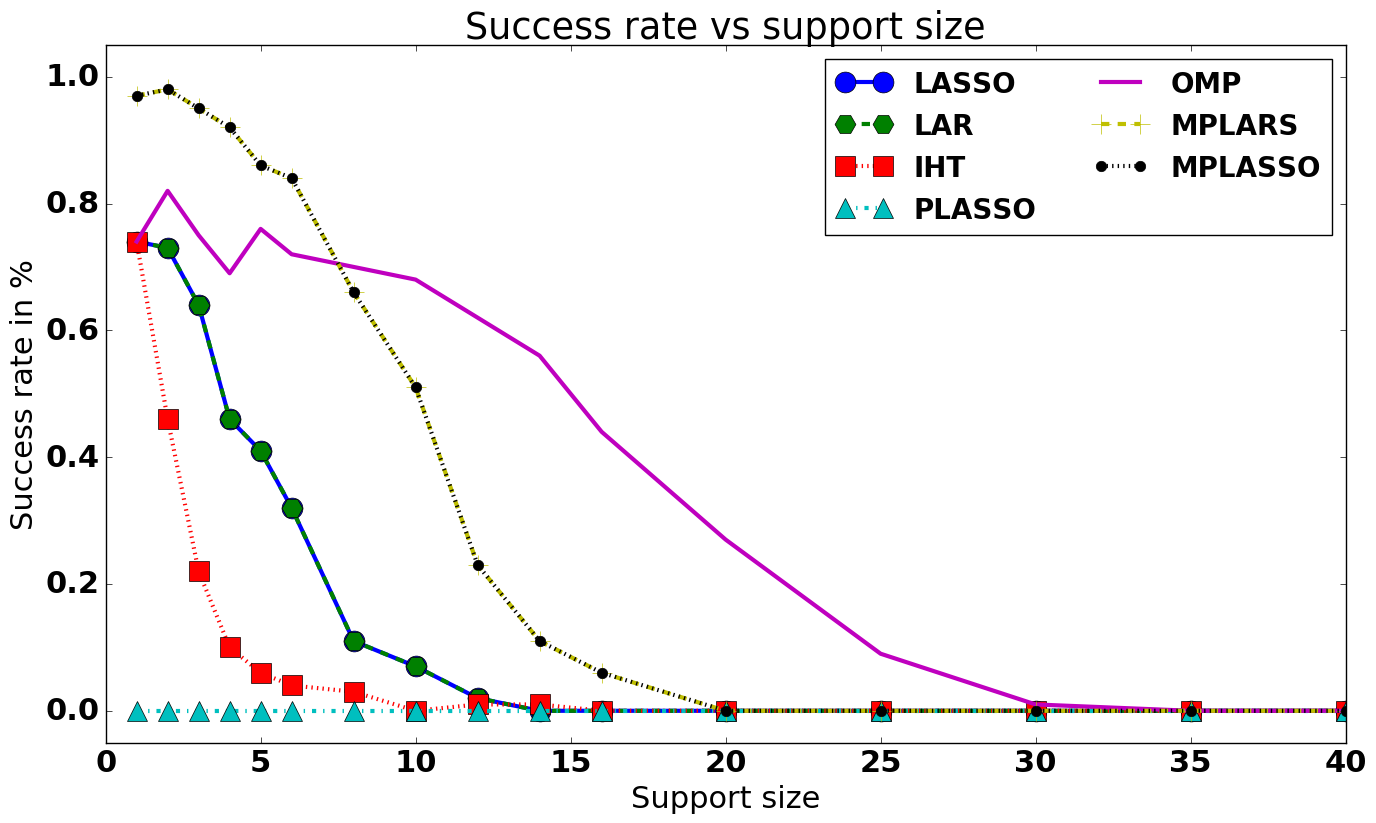

In [90]:
success_vs_sparsity_level('results_multiple_batches', identifier_mms, methods + ['mp_LARS', 'mp_LASSO'],
                         leg_loc = 'upper right', save_as = 'prcm_rm_success_vs_supportsize_1')

## 1.2 Case #measurements << #features
Here, we consider experiments where the number of number of measurements is much smaller than the number of features. The sparsity will be varied among the different cases. Additionally, we apply some measurement noise in this experiment.

In [91]:
# Specifying a problem
identifier_mms2 = 'prcm_rm_meas_much_smaller_feat_2' # For saving the files to some folder
random_seeds = [318651233, 4266868505, 2862097710, 413577336, 3099426747, 1087932463, 143461065, 2935434254, 3050947428, 
        1001518416, 2553363172, 3608867414, 1790903534, 18552655, 335443164, 989458820]
problem_mms2 = {
    'num_tests': 100, # Repititions per fixed experiment
    'n_measurements': 150, # = m 
    'n_features': 500, # = n
    'sparsity_level': [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 20, 25, 30, 35, 40], # Considered support sizes
    'smallest_signal': 1.5, # Lower bound for signal entries. One entry with smallest signal is ensured!
    'largest_signal': 5.0, # Upper bound for signal entries.
    'noise_type_signal': 'uniform_ensured_max', # Uniform sampling of entries of v + maximum will be taken.
    'noise_lev_signal': 0.2, # Bound for absolute of entires of v. 
    'noise_type_measurements': 'gaussian', # Does not matter since we have no measurement noise
    'noise_lev_measurements': 0.15, # No measurement noise
    'random_seed': list(random_seeds),
    'verbosity' : False,
    'sampling_matrix_type' : 'prcm_rademacher', # Partial random circulant for Rademacher sequences
    'problem_type' : 'unmixing',
}

#### Creating results for sparse encoders

In [92]:
%%capture
for method in methods:
    main_se(['-t', 'run', '-i', identifier_mms2, '-m', method], problem_mms2)

#### Creating results for multi-penalty framework

In [93]:
%%capture
# LARS-version
# Copy old dict
problem_mms2_mpsr = dict(problem_mms2)
# Update with multi-penalty framework properties
problem_mms2_mpsr.update({'tiling_options': tiling_options_LARS, # Options
                'beta_min': 1e-6, # Lower beta bound
                'beta_max': 100.0, # Upper beta bound
                'upper_bound_tilingcreation': [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 20, 25, 30, 35, 40]}) # Sparsity oracle
main_mp(['-t', 'run', '-i', identifier_mms2], problem_mms2_mpsr)

# LASSO-version
# Copy old dict
problem_mms2_mpsr = dict(problem_mms2)
# Update with multi-penalty framework properties
problem_mms2_mpsr.update({'tiling_options': tiling_options_LASSO, # Options
                'beta_min': 1e-6, # Lower beta bound
                'beta_max': 100.0, # Upper beta bound
                'upper_bound_tilingcreation': [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 20, 25, 30, 35, 40]}) # Sparsity oracle
main_mp(['-t', 'run', '-i', identifier_mms2], problem_mms2_mpsr)

#### Results

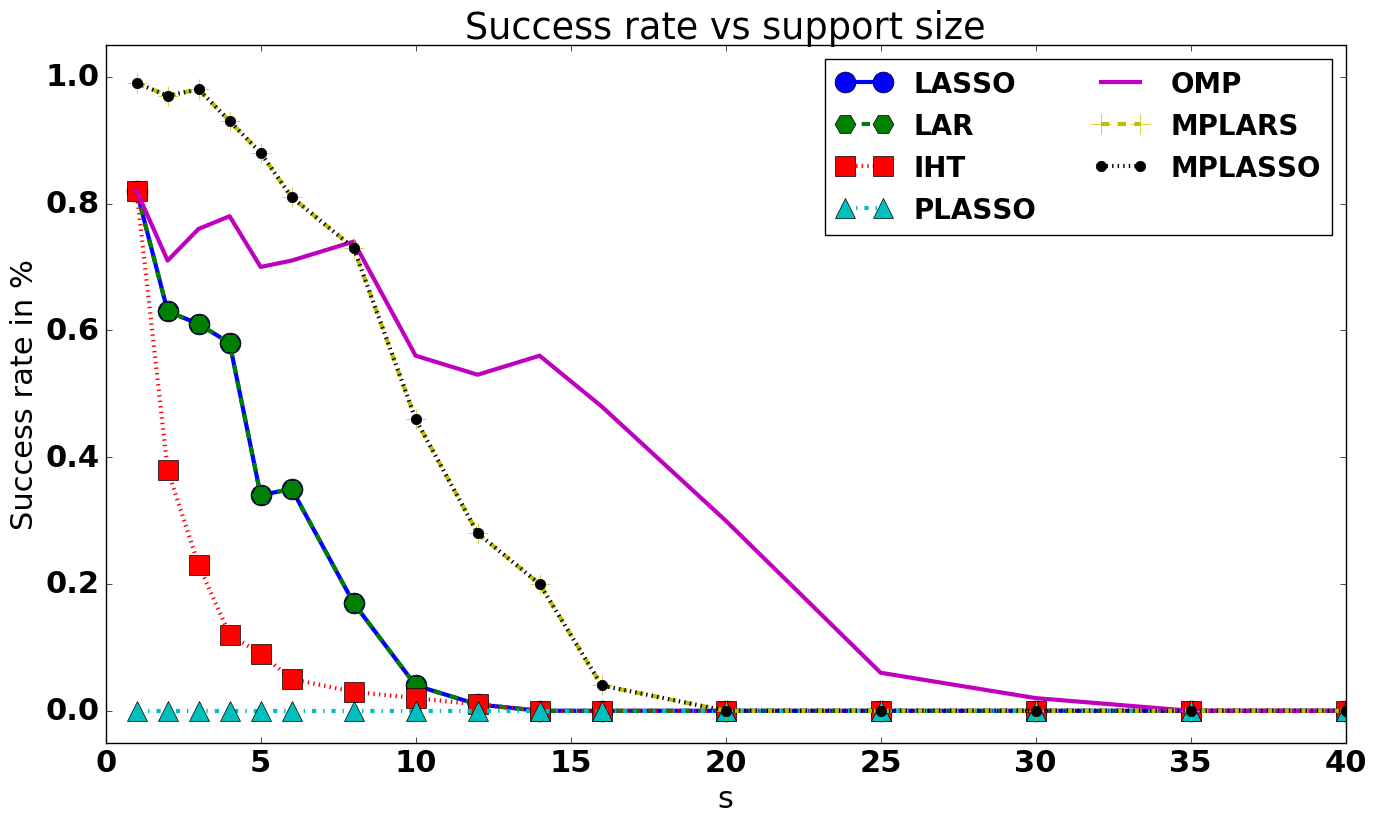

In [94]:
success_vs_sparsity_level('results_multiple_batches', identifier_mms2, methods + ['mp_LARS', 'mp_LASSO'],
                         leg_loc = 'upper right', xlabel = r's', save_as = 'prcm_rm_success_vs_supportsize_2')

## 1.3. Case #measurements << #features (high dim)
Here, we consider experiments where the number of measurements is much smaller than the number of features. The sparsity will be varied among the different cases.

In [95]:
# Specifying a problem
identifier_hd = 'prcm_rm_meas_much_smaller_feat_3' # For saving the files to some folder
random_seeds = [3107401650, 3236886930, 1595287100, 4263294224, 1058345730, 1861301578, 3913158634, 3951764974, 822410826, 
        3412174722, 1764859025, 781943365, 1574535126, 4275621399, 1718193416, 1322439636]
problem_hd = {
    'num_tests': 100, # Repititions per fixed experiment
    'n_measurements': 350, # = m 
    'n_features': 1000, # = n
    'sparsity_level': [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 20, 25, 30, 35, 40], # Considered support sizes
    'smallest_signal': 1.5, # Lower bound for signal entries. One entry with smallest signal is ensured!
    'largest_signal': 5.0, # Upper bound for signal entries.
    'noise_type_signal': 'uniform_ensured_max', # Uniform sampling of entries of v + maximum will be taken.
    'noise_lev_signal': 0.2, # Bound for absolute of entires of v. 
    'noise_type_measurements': 'gaussian', # Does not matter since we have no measurement noise
    'noise_lev_measurements': 0.0, # No measurement noise
    'random_seed': list(random_seeds),
    'verbosity' : False,
    'sampling_matrix_type' : 'prcm_rademacher', # Partial random circulant for Rademacher sequences
    'problem_type' : 'unmixing',
}

#### Creating results for sparse encoders

In [96]:
%%capture
for method in methods:
    main_se(['-t', 'run', '-i', identifier_hd, '-m', method], problem_hd)

#### Creating results for multi-penalty framework

In [97]:
%%capture
# LARS-version
# Copy old dict
problem_hd_mpsr = dict(problem_hd)
# Update with multi-penalty framework properties
problem_hd_mpsr.update({'tiling_options': tiling_options_LARS, # Options
                'beta_min': 1e-6, # Lower beta bound
                'beta_max': 100.0, # Upper beta bound
                'upper_bound_tilingcreation': [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 20, 25, 30, 35, 40]}) # Sparsity oracle
main_mp(['-t', 'run', '-i', identifier_hd], problem_hd_mpsr)

# LASSO-version
# Copy old dict
problem_hd_mpsr = dict(problem_hd)
# Update with multi-penalty framework properties
problem_hd_mpsr.update({'tiling_options': tiling_options_LASSO, # Options
                'beta_min': 1e-6, # Lower beta bound
                'beta_max': 100.0, # Upper beta bound
                'upper_bound_tilingcreation': [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 20, 25, 30, 35, 40]}) # Sparsity oracle
main_mp(['-t', 'run', '-i', identifier_hd], problem_hd_mpsr)

#### Results

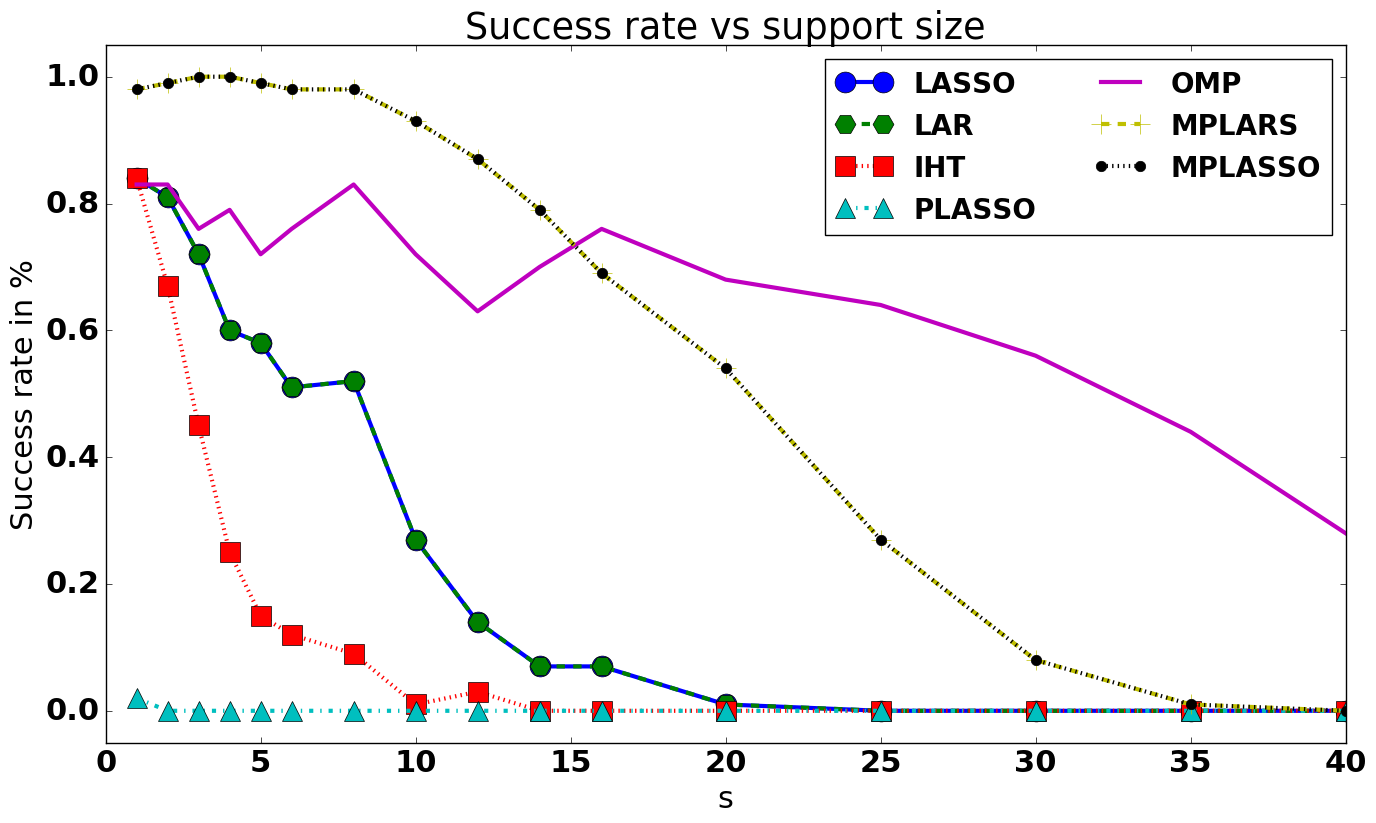

In [98]:
success_vs_sparsity_level('results_multiple_batches', identifier_hd, methods + ['mp_LARS', 'mp_LASSO'],
                        leg_loc = 'upper right', xlabel = r's', save_as = 'prcm_rm_success_vs_supportsize_3')

## 2.1. Case Dependency on signal noise for large $n$, small $m$ and small $s$
Here, we consider experiments in which we examine the dependency on signal noise and the effect of noise-folding. Specifically the matrix is sized $m=100$, $n=500$ and the support size is small with $|I|=5$.

In [99]:
# Specifying a problem
identifier_signal_noise1 = 'prcm_rm_signal_noise1' # For saving the files to some folder
random_seeds = [3925681922, 1925922750,  690608730, 4136805350, 1174167523,
        894059698,  703837878, 2008556168, 2265107943,  224641010,
       3449664981,  902617783, 4263995371, 2062887822]
problem_signal_noise1 = {
    'num_tests': 100, # Repititions per fixed experiment
    'n_measurements': 100, # = m 
    'n_features': 500, # = n
    'sparsity_level': 5, # Considered support sizes
    'smallest_signal': 1.5, # Lower bound for signal entries. One entry with smallest signal is ensured!
    'largest_signal': 5.0, # Upper bound for signal entries.
    'noise_type_signal': 'uniform_ensured_max', # Uniform sampling of entries of v + maximum will be taken.
    'noise_lev_signal': [0.0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7], # Bound for absolute of entires of v. 
    'noise_type_measurements': 'gaussian', # Does not matter since we have no measurement noise
    'noise_lev_measurements': 0.0, # No measurement noise
    'random_seed': list(random_seeds),
    'verbosity' : False,
    'sampling_matrix_type' : 'prcm_rademacher', # Partial random circulant for Rademacher sequences
    'problem_type' : 'unmixing',
}

#### Creating results for sparse encoders

In [100]:
%%capture
for method in methods:
    main_se(['-t', 'run', '-i', identifier_signal_noise1, '-m', method], problem_signal_noise1)

#### Creating results for multi-penalty framework

In [101]:
%%capture
# LARS-version
# Copy old dict
problem_signal_noise1_mpsr = dict(problem_signal_noise1)
# Update with multi-penalty framework properties
problem_signal_noise1_mpsr.update({'tiling_options': tiling_options_LARS, # Options
                'beta_min': 1e-6, # Lower beta bound
                'beta_max': 100.0, # Upper beta bound
                'upper_bound_tilingcreation': 5}) # Sparsity oracle
main_mp(['-t', 'run', '-i', identifier_signal_noise1], problem_signal_noise1_mpsr)

# LASSO-version
# Copy old dict
problem_signal_noise1_mpsr = dict(problem_signal_noise1)
# Update with multi-penalty framework properties
problem_signal_noise1_mpsr.update({'tiling_options': tiling_options_LASSO, # Options
                'beta_min': 1e-6, # Lower beta bound
                'beta_max': 100.0, # Upper beta bound
                'upper_bound_tilingcreation': 5}) # Sparsity oracle
main_mp(['-t', 'run', '-i', identifier_signal_noise1], problem_signal_noise1_mpsr)

#### Results

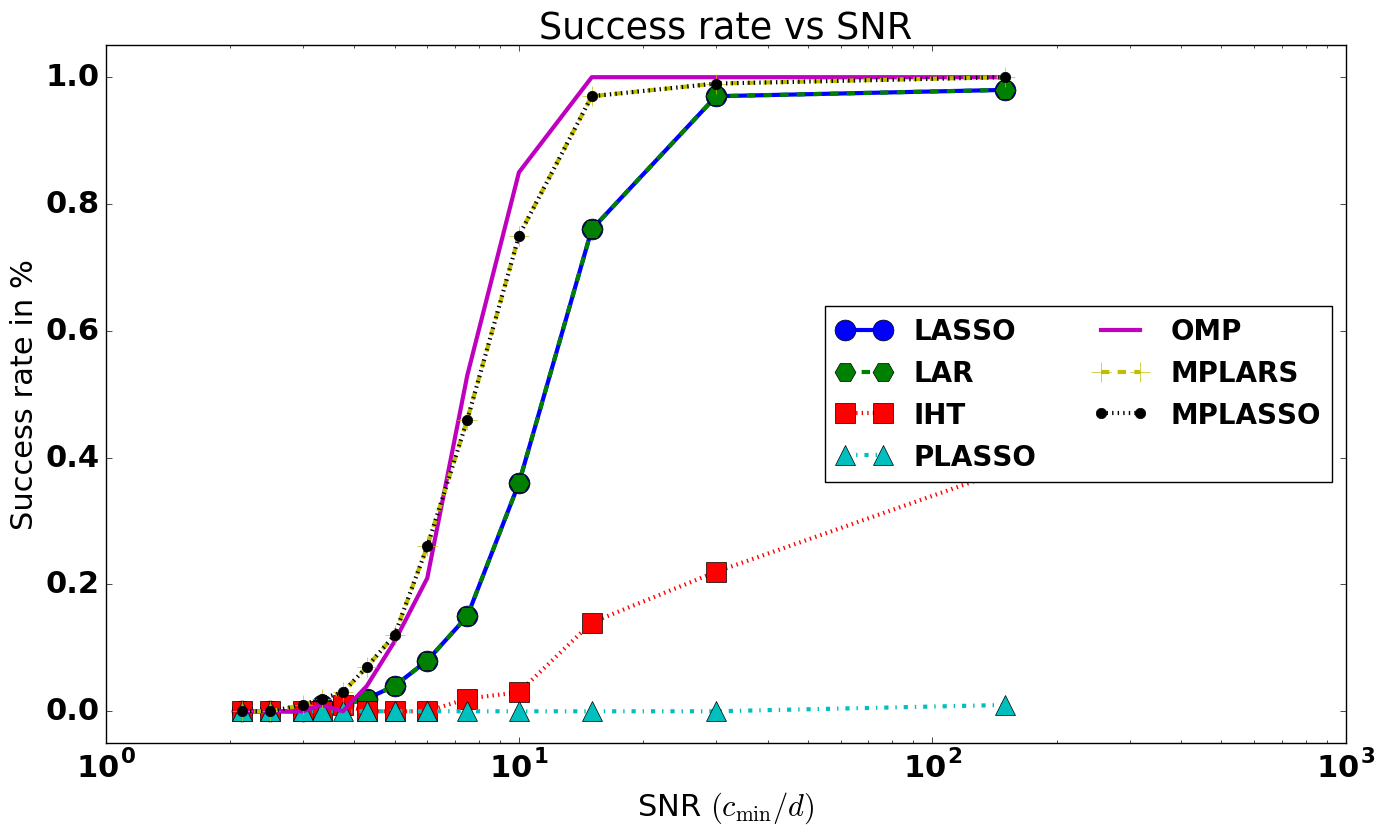

In [102]:
success_vs_signal_noise('results_multiple_batches', identifier_signal_noise1, methods + ['mp_LARS', 'mp_LASSO'],
                       leg_loc = 'center right', 
                       xlabel = r'SNR $(c_{\rm{min}}/d)$', save_as = 'prcm_rm_success_vs_snr_1')

## 2.2. Case Dependency on signal noise for large $n$, moderate $m$ and small $s$
Here, we consider experiments in which we examine the dependency on signal noise and the effect of noise-folding. Specifically the matrix is sized $m=350$, $n=1000$ and the support size is small with $|I|=7$.

In [103]:
# Specifying a problem
identifier_signal_noise2 = 'prcm_rm_signal_noise2' # For saving the files to some folder
random_seeds = [3445792111, 3152270580,  631516397,  865032037, 4221192006,
       3849748425, 3781882941, 3093467256, 1642997036, 2996623077,
       1746333050, 2926221320, 1203597124, 2274899605]
problem_signal_noise2 = {
    'num_tests': 100, # Repititions per fixed experiment
    'n_measurements': 350, # = m 
    'n_features': 1000, # = n
    'sparsity_level': 7, # Considered support sizes
    'smallest_signal': 1.5, # Lower bound for signal entries. One entry with smallest signal is ensured!
    'largest_signal': 5.0, # Upper bound for signal entries.
    'noise_type_signal': 'uniform_ensured_max', # Uniform sampling of entries of v + maximum will be taken.
    'noise_lev_signal': [0.0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7], # Bound for absolute of entires of v. 
    'noise_type_measurements': 'gaussian', # Does not matter since we have no measurement noise
    'noise_lev_measurements': 0.0, # No measurement noise
    'random_seed': list(random_seeds),
    'verbosity' : False,
    'sampling_matrix_type' : 'prcm_rademacher', # Partial random circulant for Rademacher sequences
    'problem_type' : 'unmixing',
}

#### Creating results for sparse encoders

In [104]:
%%capture
for method in methods:
    main_se(['-t', 'run', '-i', identifier_signal_noise2, '-m', method], problem_signal_noise2)

#### Creating results for multi-penalty framework

In [105]:
%%capture
# LARS-version
# Copy old dict
problem_signal_noise2_mpsr = dict(problem_signal_noise2)
# Update with multi-penalty framework properties
problem_signal_noise2_mpsr.update({'tiling_options': tiling_options_LARS, # Options
                'beta_min': 1e-6, # Lower beta bound
                'beta_max': 100.0, # Upper beta bound
                'upper_bound_tilingcreation': 7}) # Sparsity oracle
main_mp(['-t', 'run', '-i', identifier_signal_noise2], problem_signal_noise2_mpsr)

# LASSO-version
# Copy old dict
problem_signal_noise2_mpsr = dict(problem_signal_noise2)
# Update with multi-penalty framework properties
problem_signal_noise2_mpsr.update({'tiling_options': tiling_options_LASSO, # Options
                'beta_min': 1e-6, # Lower beta bound
                'beta_max': 100.0, # Upper beta bound
                'upper_bound_tilingcreation': 7}) # Sparsity oracle
main_mp(['-t', 'run', '-i', identifier_signal_noise2], problem_signal_noise2_mpsr)

#### Results

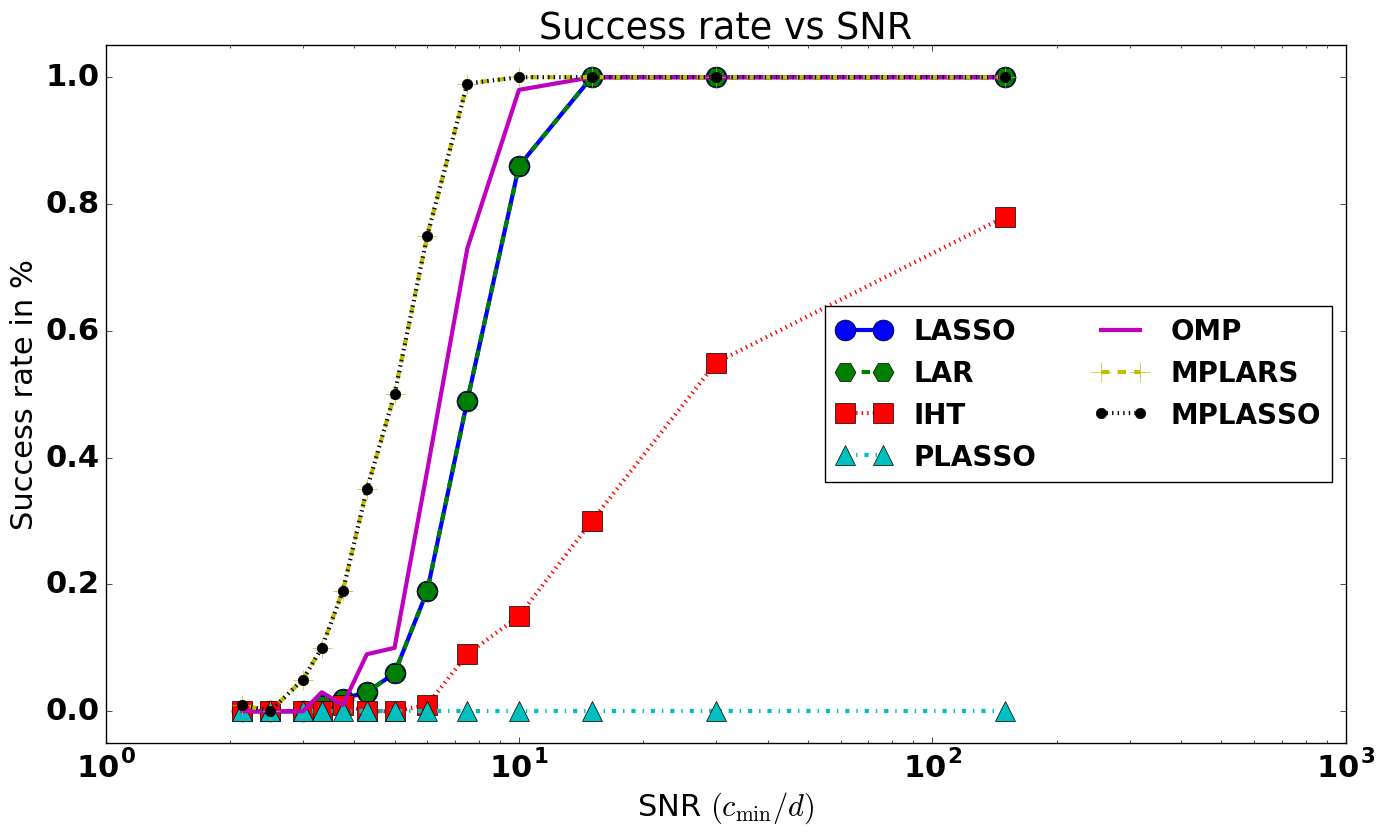

In [123]:
success_vs_signal_noise('results_multiple_batches', identifier_signal_noise2, methods + ['mp_LARS', 'mp_LASSO'],
                       leg_loc = 'center right', xlabel = r'SNR $(c_{\rm{min}}/d)$', 
                       save_as = 'prcm_rm_success_vs_snr_2')

## 2.3. Case Dependency on signal noise for large $n$, moderate $m$ and small $s$
Here, we consider experiments in which we examine the dependency on signal noise and the effect of noise-folding. Specifically the matrix is sized $m=500$, $n=2500$ and the support size is small with $|I|=9$.

In [3]:
# Specifying a problem
identifier_signal_noise3 = 'prcm_rm_signal_noise3' # For saving the files to some folder
random_seeds = [1729830023, 1916060518, 1363177418, 1103227466,  728973815,
       2561211021, 2099010721, 2535889269, 2841930523, 1973143070,
        114379252, 1141759307, 1992878642, 3859041000]
problem_signal_noise3 = {
    'num_tests': 100, # Repititions per fixed experiment
    'n_measurements': 500, # = m 
    'n_features': 2500, # = n
    'sparsity_level': 9, # Considered support sizes
    'smallest_signal': 1.5, # Lower bound for signal entries. One entry with smallest signal is ensured!
    'largest_signal': 5.0, # Upper bound for signal entries.
    'noise_type_signal': 'uniform_ensured_max', # Uniform sampling of entries of v + maximum will be taken.
    'noise_lev_signal': [0.0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7], # Bound for absolute of entires of v. 
    'noise_type_measurements': 'gaussian', # Does not matter since we have no measurement noise
    'noise_lev_measurements': 0.0, # No measurement noise
    'random_seed': list(random_seeds),
    'verbosity' : False,
    'sampling_matrix_type' : 'prcm_rademacher', # Partial random circulant for Rademacher sequences
    'problem_type' : 'unmixing',
}

#### Creating results for sparse encoders

In [4]:
%%capture
for method in methods:
    main_se(['-t', 'run', '-i', identifier_signal_noise3, '-m', method], problem_signal_noise3)

#### Creating results for multi-penalty framework

In [5]:
%%capture
# LARS-version
# Copy old dict
problem_signal_noise3_mpsr = dict(problem_signal_noise3)
# Update with multi-penalty framework properties
problem_signal_noise3_mpsr.update({'tiling_options': tiling_options_LARS, # Options
                'beta_min': 1e-6, # Lower beta bound
                'beta_max': 100.0, # Upper beta bound
                'upper_bound_tilingcreation': 9}) # Sparsity oracle
main_mp(['-t', 'run', '-i', identifier_signal_noise3], problem_signal_noise3_mpsr)

# LASSO-version
# Copy old dict
problem_signal_noise3_mpsr = dict(problem_signal_noise3)
# Update with multi-penalty framework properties
problem_signal_noise3_mpsr.update({'tiling_options': tiling_options_LASSO, # Options
                'beta_min': 1e-6, # Lower beta bound
                'beta_max': 100.0, # Upper beta bound
                'upper_bound_tilingcreation': 9}) # Sparsity oracle
main_mp(['-t', 'run', '-i', identifier_signal_noise3], problem_signal_noise3_mpsr)

#### Results

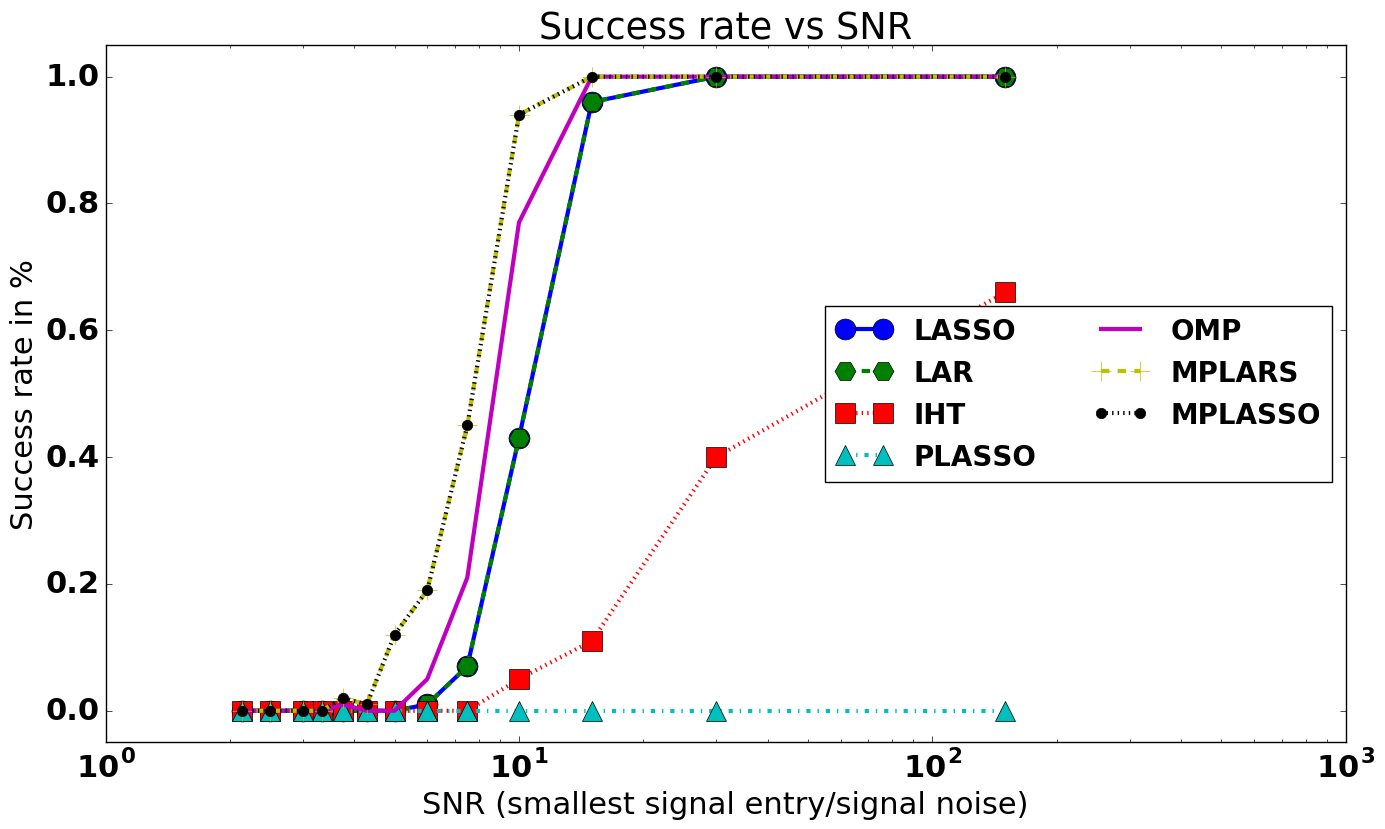

In [13]:
success_vs_signal_noise('results_multiple_batches', identifier_signal_noise3,methods + ['mp_LARS', 'mp_LASSO'],
                       leg_loc = 'center right')

## 3.1 Case Dependency signal entry gap for $m$, large $n$ and small $s$ 
Here, we consider experiments with $m = 250$, $n = 800$ and $s = |I^\dagger| = 9$ and varying signal gap, ie. we keep the signal noise and the smallest entry at $0.2$ and $1.5$ and vary the largest signal entry.

In [7]:
np.random.randint(1, 4294967295, size=(14))

array([ 886322317, 2121616294, 1203204089, 1427683375, 1691477364,
       3527212022, 1740517804,  131537535, 4152874998, 3250847343,
        530177033, 3318522708, 2953571834, 3569160583])

In [8]:
# Specifying a problem
identifier_signal_gap1 = 'prcm_rm_signal_gap1' # For saving the files to some folder
random_seeds = [ 811493389, 4279791322, 2405488816, 1356002752, 1354561538,
       1157940983, 3388634667, 1353668795,   44371308, 2190539692,
       2087811664, 2460754552,  590402847,  978808882]
problem_signal_gap1 = {
    'num_tests': 100, # Repititions per fixed experiment
    'n_measurements': 250, # = m 
    'n_features': 800, # = n
    'sparsity_level': 9, # Considered support sizes
    'smallest_signal': 1.5, # Lower bound for signal entries. One entry with smallest signal is ensured!
    'largest_signal': [1.6, 1.8, 2.0, 2.2, 2.5, 3.0, 4.0, 5.0, 7.5, 10.0, 13.5, 17.0, 20.0, 30.0], # Upper bound for signal entries.
    'noise_type_signal': 'uniform_ensured_max', # Uniform sampling of entries of v + maximum will be taken.
    'noise_lev_signal': 0.2, # Bound for absolute of entires of v. 
    'noise_type_measurements': 'gaussian', # Does not matter since we have no measurement noise
    'noise_lev_measurements': 0.0, # No measurement noise
    'random_seed': list(random_seeds),
    'verbosity' : False,
    'sampling_matrix_type' : 'prcm_rademacher', # Partial random circulant for Rademacher sequences
    'problem_type' : 'unmixing',
}

#### Creating results for sparse encoders

In [9]:
%%capture
for method in methods:
    main_se(['-t', 'run', '-i', identifier_signal_gap1, '-m', method], problem_signal_gap1)

#### Creating results for multi-penalty framework

In [10]:
%%capture
# LARS-version
# Copy old dict
problem_signal_gap1_mpsr = dict(problem_signal_gap1)
# Update with multi-penalty framework properties
problem_signal_gap1_mpsr.update({'tiling_options': tiling_options_LARS, # Options
                'beta_min': 1e-6, # Lower beta bound
                'beta_max': 100.0, # Upper beta bound
                'upper_bound_tilingcreation': 9}) # Sparsity oracle
main_mp(['-t', 'run', '-i', identifier_signal_gap1], problem_signal_gap1_mpsr)

# LASSO-version
# Copy old dict
problem_signal_gap1_mpsr = dict(problem_signal_gap1)
# Update with multi-penalty framework properties
problem_signal_gap1_mpsr.update({'tiling_options': tiling_options_LASSO, # Options
                'beta_min': 1e-6, # Lower beta bound
                'beta_max': 100.0, # Upper beta bound
                'upper_bound_tilingcreation': 9}) # Sparsity oracle
main_mp(['-t', 'run', '-i', identifier_signal_gap1], problem_signal_gap1_mpsr)

#### Results

/Users/timoklock/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


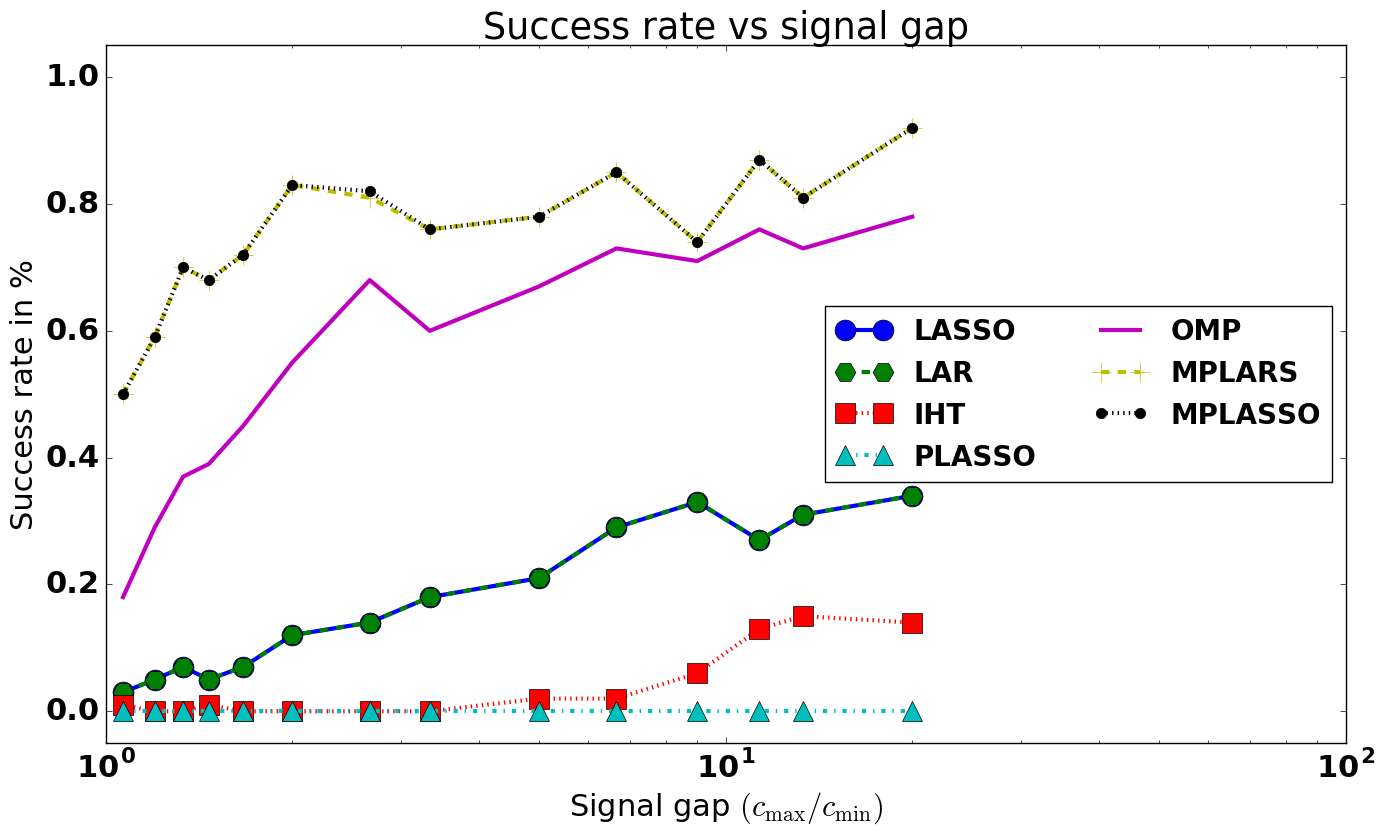

In [11]:
success_vs_signal_gap('results_multiple_batches', identifier_signal_gap1,  methods + 
                      ['mp_LARS', 'mp_LASSO'],leg_loc = 'center right', title = 'Success rate vs signal gap',
                     xlabel = r'Signal gap $(c_{\rm{max}}/c_{\rm{min}})$', save_as = 'prcm_rm_success_vs_signal_gap_1')

### Sources
1. Efron, Bradley, et al. "Least angle regression." The Annals of statistics 32.2 (2004): 407-499.
2. Blumensath, Thomas, and Mike E. Davies. "Iterative hard thresholding for compressed sensing." Applied and computational harmonic analysis 27.3 (2009): 265-274.
3. Jia, Jinzhu, and Karl Rohe. "Preconditioning to comply with the irrepresentable condition." arXiv preprint arXiv:1208.5584 (2012).
4. Tropp, Joel A., and Anna C. Gilbert. "Signal recovery from random measurements via orthogonal matching pursuit." IEEE Transactions on information theory 53.12 (2007): 4655-4666.